In [1]:
from common import plot_standings_v2, NWSL
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("rank_by_week.csv", index_col=0)
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
NJNY,1,7,8,10,10,5,7,8,10,8,9,9,11,11,12,12,12,12,12,12
POR,2,2,3,7,8,4,3,2,3,3,2,2,1,1,1,4,2,4,1,2
LA,3,6,2,2,2,7,4,6,6,5,7,7,7,7,7,7,7,7,8,8
CHI,4,4,6,6,7,3,2,3,2,2,3,4,4,6,6,6,6,6,7,6
WAS,5,3,7,8,9,10,8,7,9,11,11,10,10,10,11,11,10,10,11,11
SD,6,1,1,1,1,1,1,1,1,1,1,1,2,3,2,1,3,1,4,3
NC,7,11,12,12,12,12,12,12,12,12,12,12,12,12,10,9,8,8,6,7
RGN,8,10,10,9,3,6,6,5,4,4,6,5,6,5,5,5,5,5,2,1
LOU,9,9,9,3,5,8,9,9,8,10,10,11,9,9,9,10,11,11,10,9
HOU,10,5,4,4,4,2,5,4,5,6,4,3,3,2,3,2,4,2,5,4


In [3]:
# Create fake data for the standings table
df_table = pd.DataFrame([])
df_table.index = df.index
for col in ["MP", "W", "L", "D", "GF", "GA", "GD", "PTS"]:
    df_table[col] = 1

/home/agale/nwsl-analytics/src/common/plot_standings.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 432x288 with 0 Axes>

<Figure size 2400x1350 with 0 Axes>

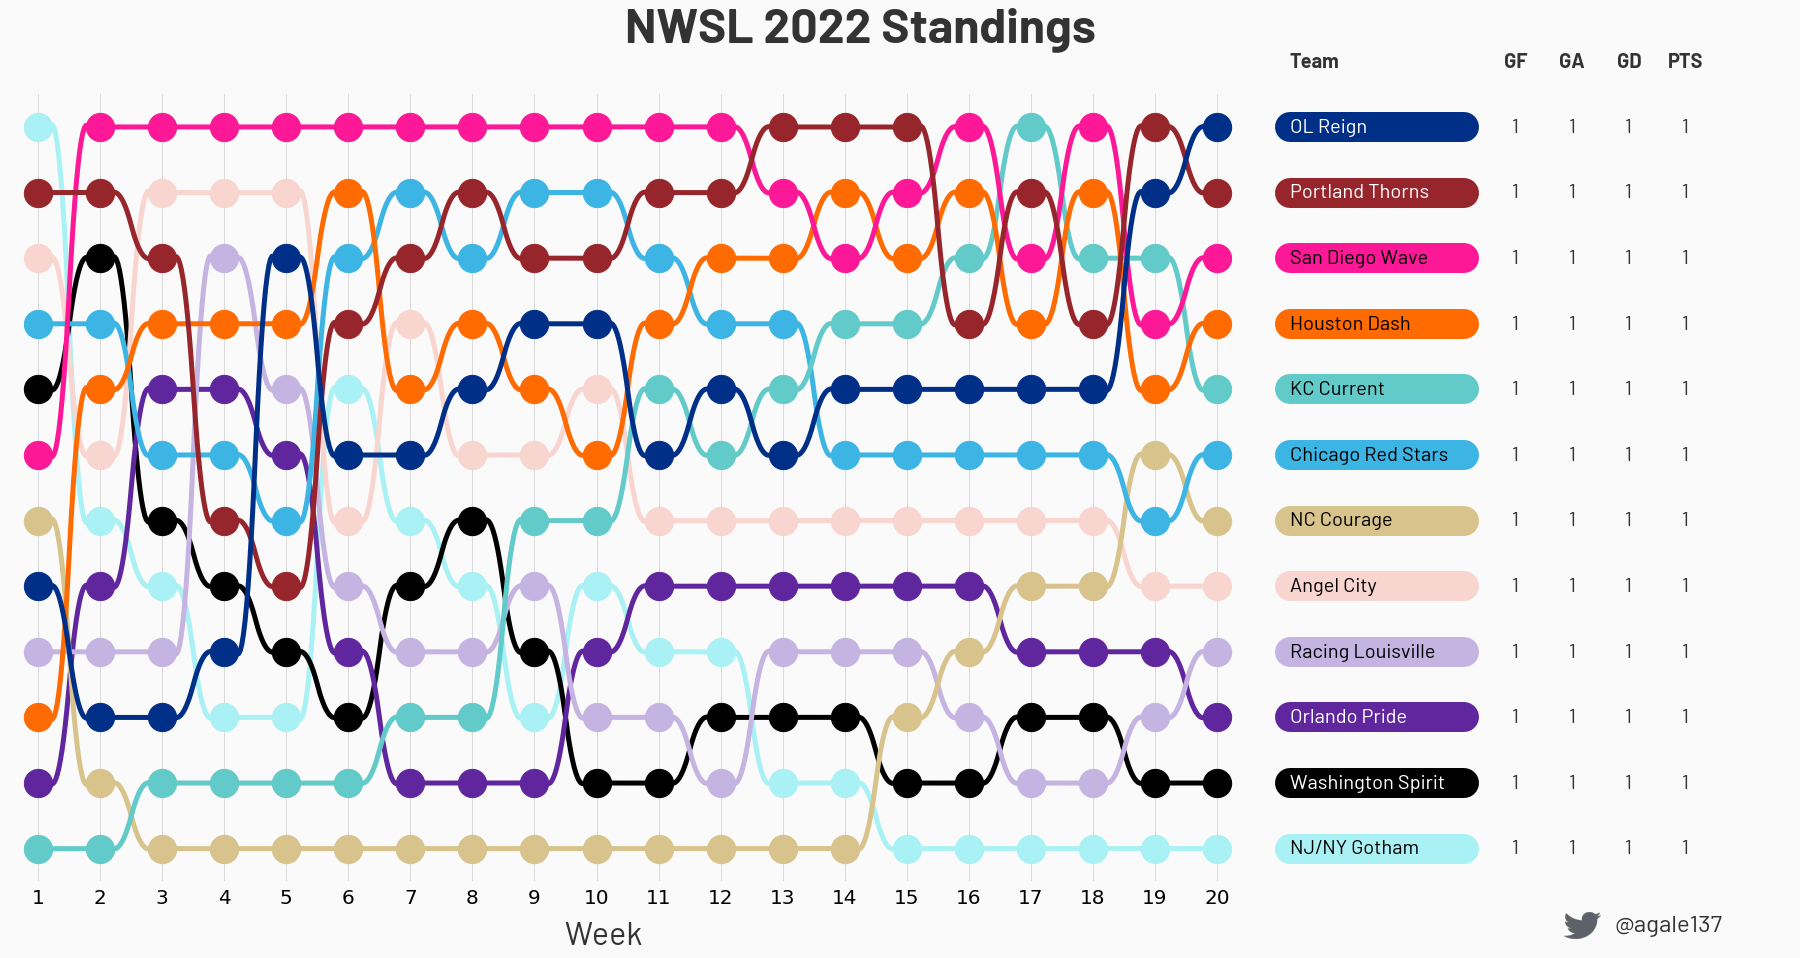

In [4]:
plot_standings_v2(
    df,
    df_table[["MP", "GF", "GA", "GD", "PTS"]],
    folder="images",
    playoff_cutoff=6,
    names=NWSL.NAMES,
    colors=NWSL.COLORS,
    text_colors=NWSL.TEXT_COLORS,
    title="NWSL 2022 Standings",
    label_width=0.37,
    twitter_x=0.9,
    cubic_p=0.25,
)

/home/agale/nwsl-analytics/src/common/plot_standings.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 1728x972 with 0 Axes>

<Figure size 2000x1350 with 0 Axes>

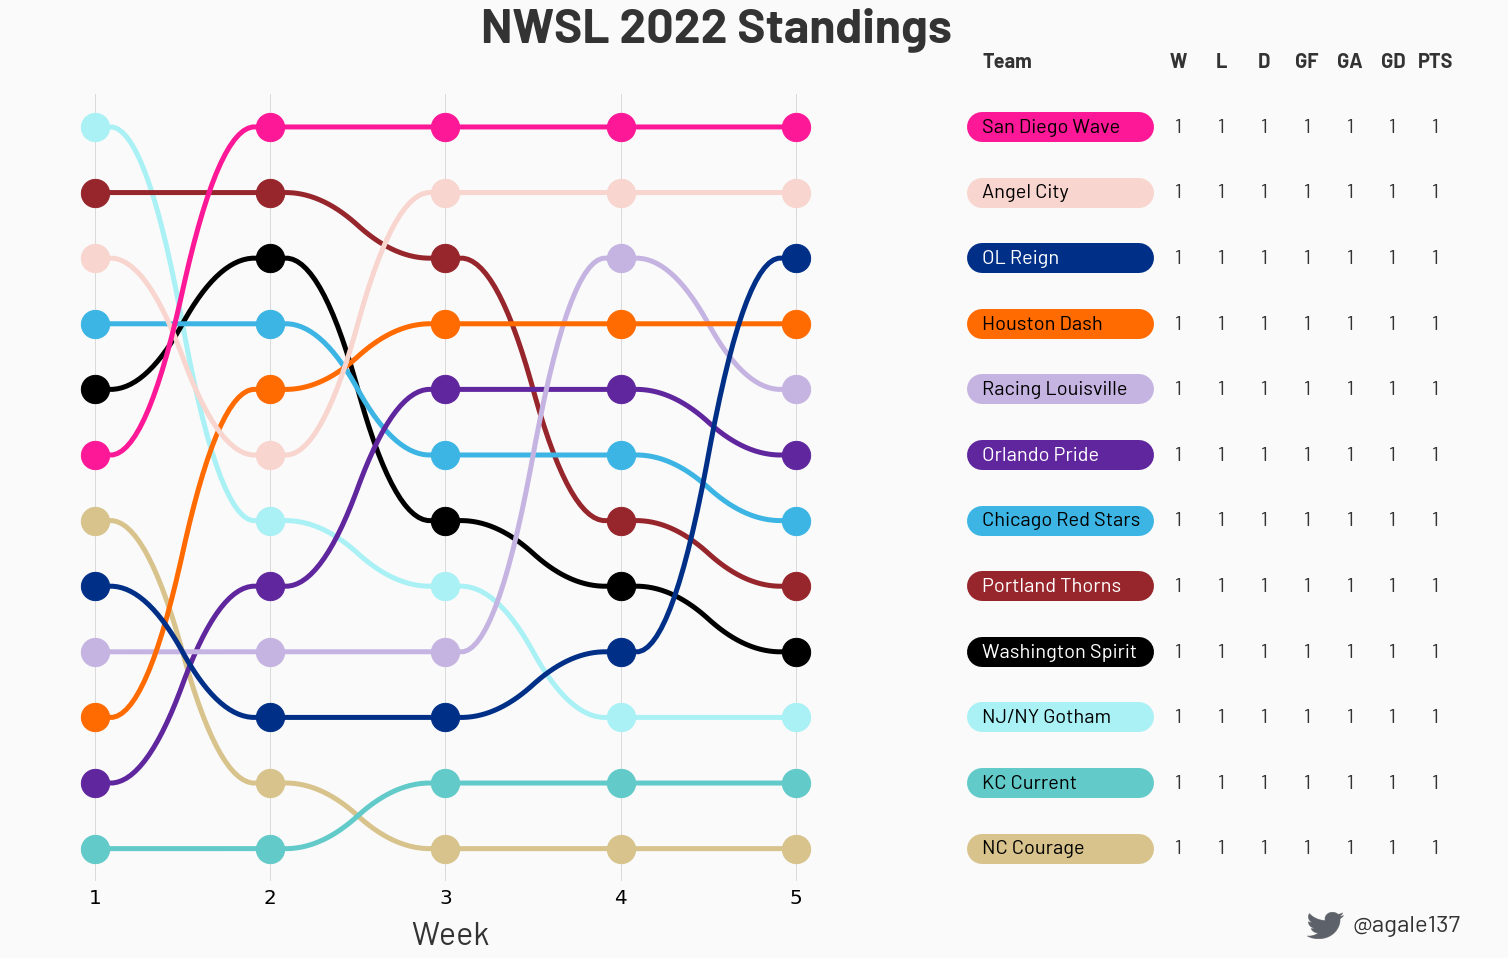

In [5]:
plot_standings_v2(
    df[["1", "2", "3", "4", "5"]],
    df_table,
    folder="images",
    playoff_cutoff=6,
    names=NWSL.NAMES,
    colors=NWSL.COLORS,
    text_colors=NWSL.TEXT_COLORS,
    title="NWSL 2022 Standings",
    label_width=0.44,
    twitter_x=0.905
)